# 10-5 VGG for cifar10

## original code is =>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [28]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
#%pip install visdom

In [ ]:
#python -m visdom.server

# 서버 접속

In [30]:
import visdom

vis = visdom.Visdom()
vis.close(env = 'main')


Setting up a new session...


''

In [31]:
vis.text("Hello wolrd", env="main")

'window_3c1d99cea440e0'

## define loss tracker

In [32]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [33]:
device = torch.device("mps")

torch.manual_seed(777)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
#if device =='cuda':
#    torch.cuda.manual_seed_all(777)


In [34]:
device

device(type='mps')

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


cifar 10 : 32 x 32 x 3 images

maxpooling을 때려서 7x7보다 작게 나오게 하려면 32 - 16 - 8 - 4  세 번 필요

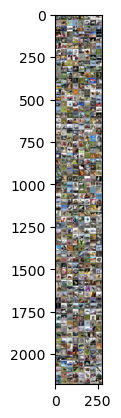

truck   car   car   cat


In [36]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
vis.images(images/2 + 0.5)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## make VGG16 using vgg.py

In [37]:
import torchvision.models.vgg as vgg

In [38]:
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

### Adaptive Average Pooling
- 주어진 출력 크기에 맞추기 위해 입력 이미지의 특징 맵을 평균값으로 변환하는 작업을 수행 
- 이를 통해 네트워크가 이미지의 전역적인 특징을 고정된 크기의 출력으로 요약함

In [39]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) # 내 이미지가 7 by 보다 작게 되면 굳이 쓸 이유가 없음
        
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), # 4 by 4  -> max pooling 3번으로 512, 4, 4가 됨
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # Kaiming He
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [40]:
vgg16= VGG(vgg.make_layers(cfg),10,True).to(device)

In [42]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[ 2.7634e+33, -4.9067e+32,  1.9952e+33, -2.7537e+33, -4.9787e+33,
          8.0313e+32,  1.2998e+33, -1.5992e+33,  4.2153e+33, -4.0030e+33]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [43]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005,momentum=0.9)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

## make plot

In [44]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

## training

In [45]:
print(len(trainloader))
epochs = 30 #50정도 돌려야 어느 정도 나오는 듯?

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
        

print('Finished Training')

98


/Users/a05/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1,    30] loss: 2.302
[1,    60] loss: 2.297
[1,    90] loss: 2.288
[2,    30] loss: 2.168
[2,    60] loss: 2.030
[2,    90] loss: 1.938
[3,    30] loss: 1.871
[3,    60] loss: 1.758
[3,    90] loss: 1.705
[4,    30] loss: 1.658
[4,    60] loss: 1.626
[4,    90] loss: 1.551
[5,    30] loss: 1.526
[5,    60] loss: 1.509
[5,    90] loss: 1.458
[6,    30] loss: 1.411
[6,    60] loss: 1.426
[6,    90] loss: 1.363
[7,    30] loss: 1.348
[7,    60] loss: 1.323
[7,    90] loss: 1.299
[8,    30] loss: 1.234
[8,    60] loss: 1.196
[8,    90] loss: 1.195
[9,    30] loss: 1.138
[9,    60] loss: 1.125
[9,    90] loss: 1.158
[10,    30] loss: 1.055
[10,    60] loss: 1.053
[10,    90] loss: 1.046
[11,    30] loss: 0.977
[11,    60] loss: 1.026
[11,    90] loss: 1.009
[12,    30] loss: 0.952
[12,    60] loss: 0.938
[12,    90] loss: 0.933
[13,    30] loss: 0.889
[13,    60] loss: 0.880
[13,    90] loss: 0.907
[14,    30] loss: 0.829
[14,    60] loss: 0.849
[14,    90] loss: 0.870
[15,    30] loss: 0

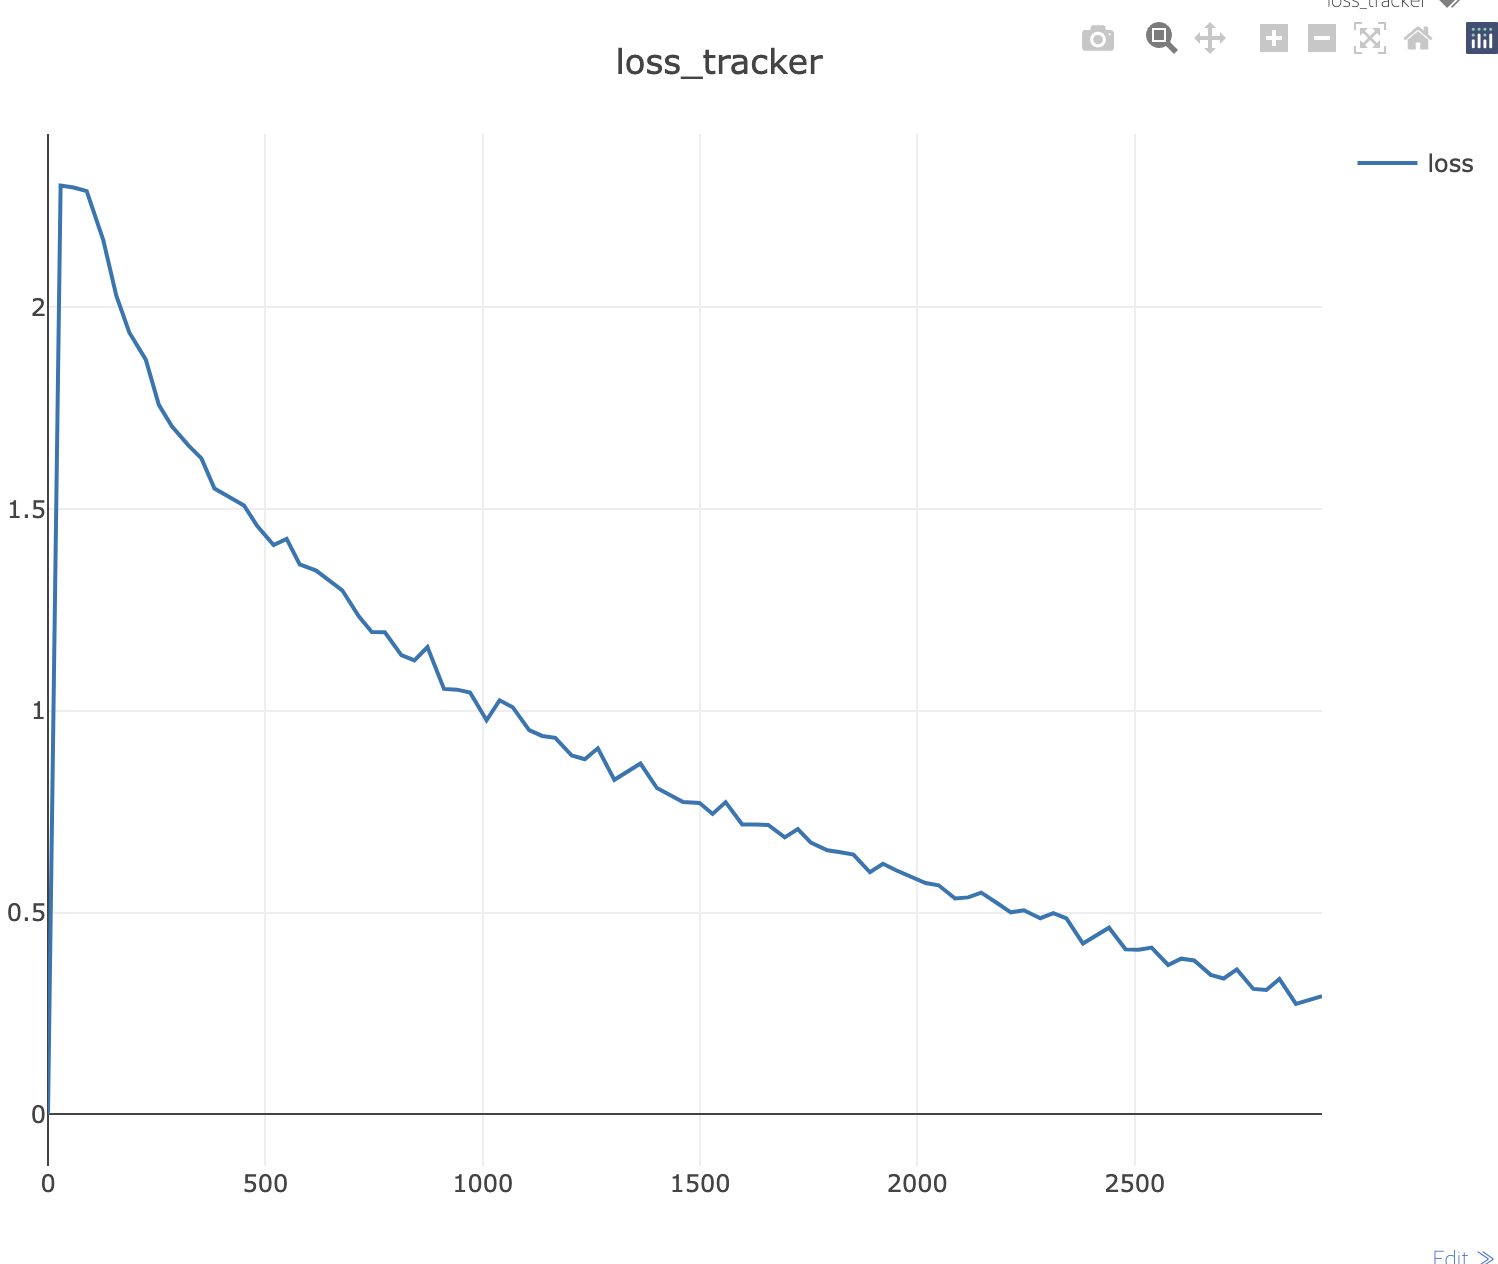

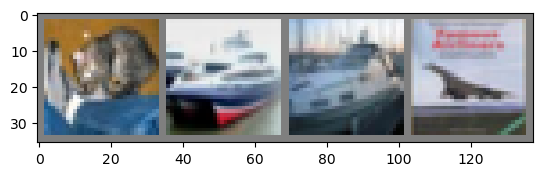

GroundTruth:    cat  ship  ship plane


In [46]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [47]:
outputs = vgg16(images.to(device))

In [48]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [49]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %
